In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
#dataset = load("moon.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
variant = :sigma
    # :unit - output has unit variance
    # :sigma - the variance of the output is estimated
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
# decoder architecture
(variant == :unit)? dsize = [latentdim; hiddendim; hiddendim; indim] :
    dsize = [latentdim; hiddendim; hiddendim; 2*indim]
lambda = 1e-3 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
batchsize = 50 # batchsize 
nepochs = Int(ceil(batchsize*iterations/size(nX,2))) # if this is supplied, do epoch training
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = Inf # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
eta = 0.001
model = VAEmodel(esize, dsize, lambda = lambda, threshold = threshold, 
    contamination = contamination, iterations = iterations, cbit = cbit, 
    nepochs = nepochs,
    verbfit = verbfit, batchsize = batchsize, M=M, activation = activation, 
    layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked, variant = variant, eta = eta)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#samplenormal,Flux.Chain,Val{:sigma}}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.samplenormal, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), Val{:sigma}()), 0.001, 0, 0.1262135922330097, 2000, 500, 1112, true, 50, 1, Inf32, 1.0f0, MVHistory{ValueHistories.History}, "likelihood", 0.001)

In [4]:
# fit the model
println("\ninitial loss")
AnomalyDetection.evalloss(model, nX)
@time AnomalyDetection.fit!(model, nX)
println("\nfinal loss")
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)


initial loss
loss: 0.47172123
likelihood: 0.48626116
KL: 0.14480564



Progress:   0%|                                         |  ETA: 3:51:27
  loss:        0.53341293
  likelihood:  0.5306731
Progress:   3%|█                                        |  ETA: 0:03:50
  loss:        -0.17944975
  likelihood:  -0.21599257
Progress:   5%|██                                       |  ETA: 0:02:52
  loss:        -0.59587866
  likelihood:  -0.58626616
Progress:   6%|██                                       |  ETA: 0:02:14
  loss:        -1.0377301
  likelihood:  -1.0527036
Progress:   8%|███                                      |  ETA: 0:01:43
  loss:        -1.9572598
  likelihood:  -2.0214062
Progress:   9%|████                                     |  ETA: 0:01:32
  loss:        -2.3839874
  likelihood:  -2.3293388
Progress:  10%|████                                     |  ETA: 0:01:23
  loss:        -2.6077728
  likelihood:  -2.7106433
Progress:  11%|█████                                    |  ETA: 0:01:17
  loss:        -3.145069
  likelihood:  -3.1216767
Progre

Progress:  71%|█████████████████████████████            |  ETA: 0:00:10
  loss:        -5.7557883
  likelihood:  -5.790906
Progress:  72%|██████████████████████████████           |  ETA: 0:00:09
  loss:        -5.7942495
  likelihood:  -5.8266654
Progress:  74%|██████████████████████████████           |  ETA: 0:00:09
  loss:        -5.8804054
  likelihood:  -5.9188585
Progress:  75%|███████████████████████████████          |  ETA: 0:00:08
  loss:        -6.0141277
  likelihood:  -6.054139
Progress:  77%|████████████████████████████████         |  ETA: 0:00:08
  loss:        -6.1005864
  likelihood:  -6.133011
Progress:  79%|████████████████████████████████         |  ETA: 0:00:07
  loss:        -6.2440853
  likelihood:  -6.285434
Progress:  80%|█████████████████████████████████        |  ETA: 0:00:06
  loss:        -6.3086557
  likelihood:  -6.3467627
Progress:  81%|█████████████████████████████████        |  ETA: 0:00:06
  loss:        -6.3692527
  likelihood:  -6.4066725
Progress:  8

 35.712298 seconds (29.66 M allocations: 2.766 GiB, 3.78% gc time)

final loss
loss: -6.730298
likelihood: -6.768258
KL: 39.16932



-6.2442436f0

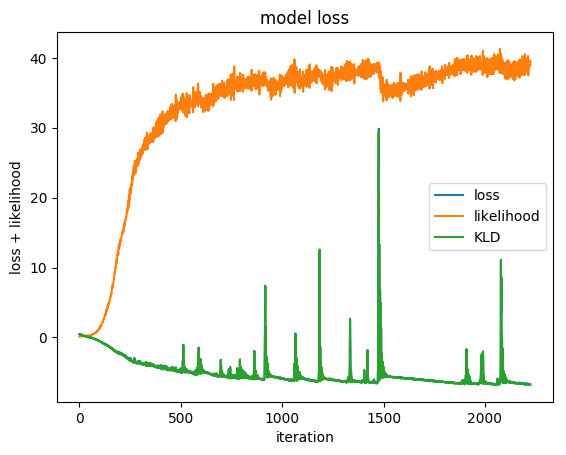

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 4×90 Array{Float32,2}:
   0.574897    0.568819    0.574799  …    0.282139    0.272563    0.291423
   0.82225     0.834207    0.826084       0.97428     1.00717     0.97361 
  -3.23685    -3.24942    -3.24339       -3.10466    -3.14891    -3.11607 
 -12.2682    -12.3595    -12.3087       -12.1215    -12.416     -12.1707  

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mux(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.574201  0.569332  0.572908  0.567109  …  0.280978  0.273313  0.291411
 0.822917  0.835353  0.826671  0.848613     0.974467  1.00768   0.973651

In [9]:
AnomalyDetection.sigma2x(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.0385968   0.0380106   0.0383099   …  0.0439175   0.0419996   0.0433298 
 5.76836f-6  5.29153f-6  5.52994f-6     6.48361f-6  5.05311f-6  6.12599f-6

What are the parameters of $q(z|x)$?

In [10]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
 2.73485  2.76623  2.74476  2.79919  …  3.37243  3.28526  3.36644  3.27665
 7.56604  7.62969  7.59278  7.72378     7.20022  7.1119   7.32308  7.16172

In [11]:
AnomalyDetection.sigma2z(model, nX)

Tracked 2×90 Array{Float32,2}:
 1.11921f-6  1.11921f-6  1.11921f-6  …  1.59605f-6  1.35763f-6  1.47684f-6
 1.06559f-5  9.70224f-6  1.02983f-5     1.85236f-5  1.38745f-5  1.73315f-5

What do the codes look like?

In [12]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 2.73546  2.76499  2.74493  2.79745  …  3.37108  3.28597  3.3663   3.27667
 7.5646   7.63473  7.59768  7.72818     7.2003   7.11609  7.32308  7.16001

In [13]:
# predict labels on testing data
model.M = 10 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1

In [14]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 87
  fp = 3
  fn = 2
precision: 0.7857142857142857
f1score: 0.8148148148148148
recall: 0.8461538461538461
false positive rate: 0.03333333333333333
equal error rate: 0.09358974358974359

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 86
  fp = 4
  fn = 2
precision: 0.7333333333333333
f1score: 0.7857142857142857
recall: 0.8461538461538461
false positive rate: 0.044444444444444446
equal error rate: 0.09914529914529915


In [15]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 30);

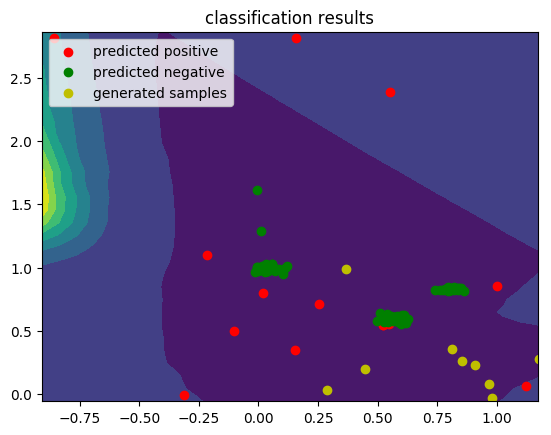

In [16]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

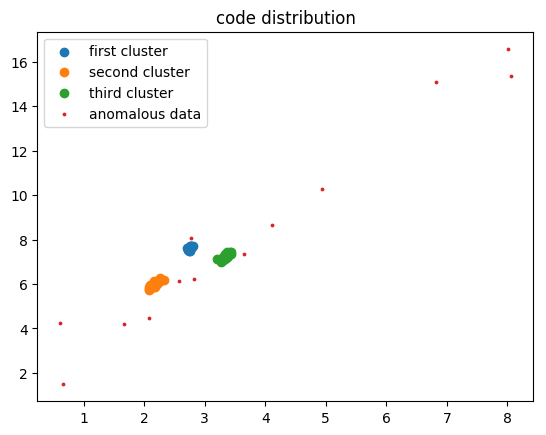

In [17]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

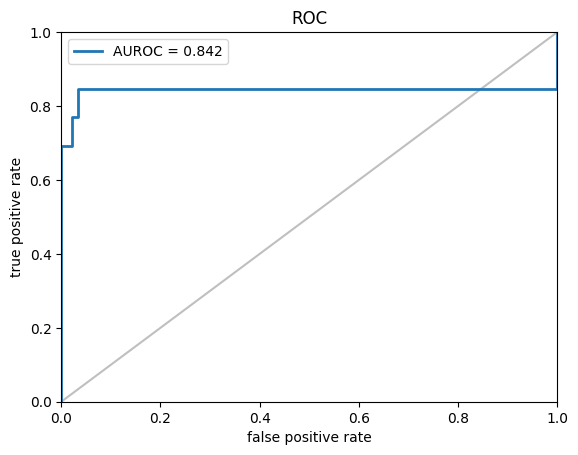

In [18]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()